In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.optim.lr_scheduler import StepLR

from torch.utils.data import random_split
%matplotlib inline

Download the data and create a PyTorch dataset using the MNIST class from torchvision.datasets.

In [ ]:
batch_size=128
val_size = 10000

torch.manual_seed(1)


dataset = MNIST(root='data/', download=True, transform=ToTensor())

train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

Calculate the Mean and standard

In [ ]:
train_mean = 0.
train_std = 0.
for images, _ in train_loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)

    train_mean += images.mean(2).sum(0)
    train_std += images.std(2).sum(0)

train_mean /= len(train_loader.dataset)
train_std /= len(train_loader.dataset)

print('Mean: ', train_mean)
print('Std: ', train_std)

Mean:  tensor([0.1307])
Std:  tensor([0.3016])


**Data Augmentation / Image transformation**

In [ ]:
dataset = MNIST(root='data/', download=True, transform=transforms.Compose([
                        transforms.RandomRotation((-7.0,7.0),fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1308,), (0.3016,))
                    ]))
test_dataset = MNIST(root='data/', train=False,transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1308,), (0.3016,))
                    ]))

In [ ]:
torch.manual_seed(1)

val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [ ]:
batch_size=128

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

**Sanity check**

min value tensor(-0.4337)
max value tensor(2.8820)
Mean tensor(0.0185)
Std deviation tensor(1.0406)


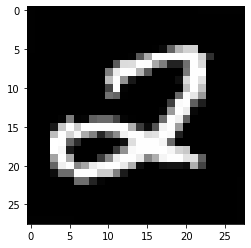

In [ ]:
# sanity check for training data
imgs, lbls = next(iter(train_loader))
imgs[7].data.shape
print("min value", imgs.data.min())
print("max value",imgs.data.max())
print("Mean",imgs.data.mean())
print("Std deviation",imgs.data.std())
plt.imshow(imgs[0].data.reshape((28,28)), cmap="gray")

In [ ]:
def show_batch(dl, invert=False):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

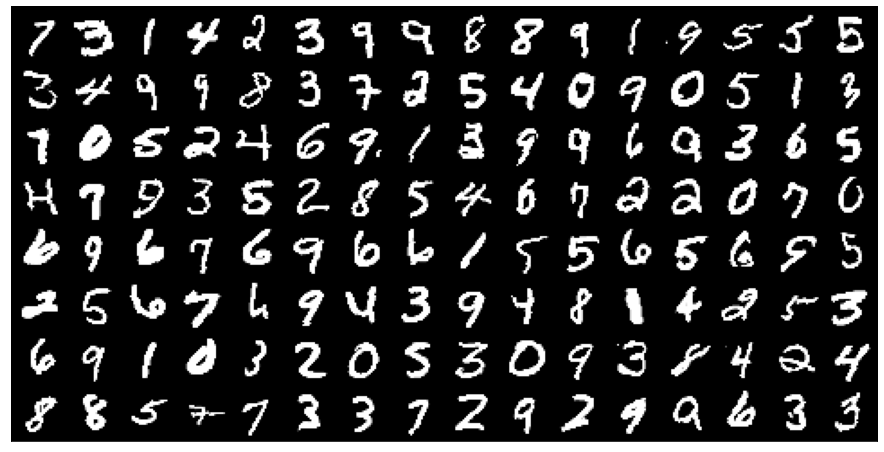

In [ ]:
show_batch(train_loader)

**Evaluation Metric and Loss Function**

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class MnistModelBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        acc = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_acc': acc }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result,LR):
        print("Epoch [{}] - LR [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,LR,result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class MnistModel(MnistModelBase):
    """Feedfoward neural network with 2 hidden layer"""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size=3),   #RF - 3x3 # 26x26
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),

            nn.Conv2d(16, 16, 3),   #RF - 5x5 # 24x24
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),

            nn.Conv2d(16, 32, 3),   #RF - 7x7 # 22x22
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.1),
        )

        # translation layer
        # input - 22x22x64; output - 11x11x32
        self.trans1 = nn.Sequential(
            # RF - 7x7
            nn.Conv2d(32, 20, 1), # 22x22
            nn.ReLU(),
            nn.BatchNorm2d(20),


            # RF - 14x14
            nn.MaxPool2d(2, 2), # 11x11
        )

        self.conv2 = nn.Sequential(
            
            nn.Conv2d(20,20,3,padding=1),   #RF - 16x16 #output- 9x9
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout2d(0.1),

            nn.Conv2d(20,16,3),   #RF - 16x16 #output- 9x9
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),

            nn.Conv2d(16, 16, 3),   #RF - 18x18 #output- 7x7
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),
        ) 

         
        self.conv3 = nn.Sequential(
            nn.Conv2d(16,16,3),   #RF - 20x20  #output- 5x5
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),

            #nn.Conv2d(16,10,1),   #RF - 20x20  #output- 7x7

        )   

        # GAP Layer
        self.avg_pool = nn.Sequential(
            # # RF - 22x22
            nn.AvgPool2d(5)
        )   ## output_size=1  

        self.conv4 = nn.Sequential(
  
            nn.Conv2d(16,10,1),   #RF - 20x20  #output- 7x7

        )  

        
    def forward(self, xb):
        x = self.conv1(xb)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avg_pool(x)
        x = self.conv4(x)

        x = x.view(-1, 10)
        return x

Using a GPU

In [ ]:
#function to ensure that our code uses the GPU if available, and defaults to using the CPU if it isn't.
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
# a function that can move data and model to a chosen device.    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


#Finally, we define a DeviceDataLoader class to wrap our existing data loaders and move data to the selected device, 
#as a batches are accessed. Interestingly, we don't need to extend an existing class to create a PyTorch dataloader. 
#All we need is an __iter__ method to retrieve batches of data, and an __len__ method to get the number of batches.

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

**We can now wrap our data loaders using DeviceDataLoader.**

In [ ]:
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

**Model Training**

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    scheduler = OneCycleLR(optimizer, lr, epochs=epochs,steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            scheduler.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result,scheduler.get_lr())
        history.append(result)
    return history

In [ ]:
# Model (on GPU)
model = MnistModel()
to_device(model, device)

MnistModel(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout2d(p=0.1, inplace=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout2d(p=0.1, inplace=False)
  )
  (trans1): Sequential(
    (0): Conv2d(32, 20, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), st

**Print Summary of the model**

In [ ]:
from torchsummary import summary
# print the summary of the model
summary(model, input_size=(1, 28, 28), batch_size=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
         Dropout2d-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,320
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
         Dropout2d-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 32, 22, 22]           4,640
             ReLU-10           [-1, 32, 22, 22]               0
      BatchNorm2d-11           [-1, 32, 22, 22]              64
        Dropout2d-12           [-1, 32, 22, 22]               0
           Conv2d-13           [-1, 20, 22, 22]             660
             ReLU-14           [-1, 20,

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.316545248031616, 'val_acc': 0.08847656100988388}]

In [ ]:
history += fit(10, 0.01, model, train_loader, val_loader)

Epoch [0] - LR [[0.002803715222454561]], train_loss: 1.5760, val_loss: 0.4536, val_acc: 0.9362


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:1679: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch [1] - LR [[0.007607424693710002]], train_loss: 0.3285, val_loss: 0.0890, val_acc: 0.9770
Epoch [2] - LR [[0.009999996706267125]], train_loss: 0.1538, val_loss: 0.0555, val_acc: 0.9829
Epoch [3] - LR [[0.009502353253541814]], train_loss: 0.1157, val_loss: 0.0509, val_acc: 0.9838
Epoch [4] - LR [[0.00811296748245884]], train_loss: 0.0974, val_loss: 0.0396, val_acc: 0.9877
Epoch [5] - LR [[0.006107024284679441]], train_loss: 0.0819, val_loss: 0.0348, val_acc: 0.9885
Epoch [6] - LR [[0.003881825311802684]], train_loss: 0.0762, val_loss: 0.0323, val_acc: 0.9907
Epoch [7] - LR [[0.0018780985106812938]], train_loss: 0.0675, val_loss: 0.0282, val_acc: 0.9913
Epoch [8] - LR [[0.0004927065483738951]], train_loss: 0.0624, val_loss: 0.0268, val_acc: 0.9919
Epoch [9] - LR [[4.329373287369841e-08]], train_loss: 0.0576, val_loss: 0.0258, val_acc: 0.9917


In [ ]:
def plot_scores(history):
#     scores = [x['val_score'] for x in history]
    acc = [x['val_acc'] for x in history]
    plt.plot(acc, '-x')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.title('acc vs. No. of epochs');

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

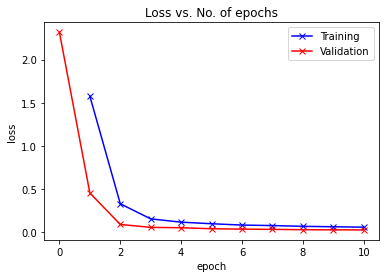

In [ ]:
plot_losses(history)

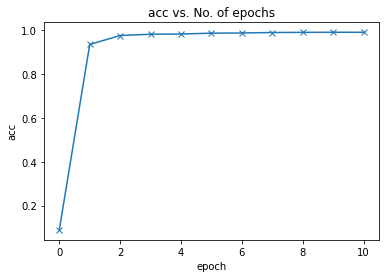

In [ ]:
plot_scores(history)

In [ ]:
def get_misclassified(model, test_loader):
    misclassified = []
    misclassified_pred = []
    misclassified_target = []
    # put the model to evaluation mode
    model.eval()
    # turn off gradients

    with torch.no_grad():
        for data, target in test_loader:

            # do inferencing
            output = model(data)
            # get the predicted output
            pred = output.argmax(dim=1, keepdim=True)

            # get the current misclassified in this batch
            list_misclassified = (pred.eq(target.view_as(pred)) == False)
            batch_misclassified = data[list_misclassified]
            batch_mis_pred = pred[list_misclassified]
            batch_mis_target = target.view_as(pred)[list_misclassified]

            # batch_misclassified =

            misclassified.append(batch_misclassified)
            misclassified_pred.append(batch_mis_pred)
            misclassified_target.append(batch_mis_target)
    # group all the batches together
    misclassified = torch.cat(misclassified)
    misclassified_pred = torch.cat(misclassified_pred)
    misclassified_target = torch.cat(misclassified_target)

    return list(map(lambda x, y, z: (x, y, z), misclassified, misclassified_pred, misclassified_target))

In [ ]:
misclassified = get_misclassified(model, test_loader)

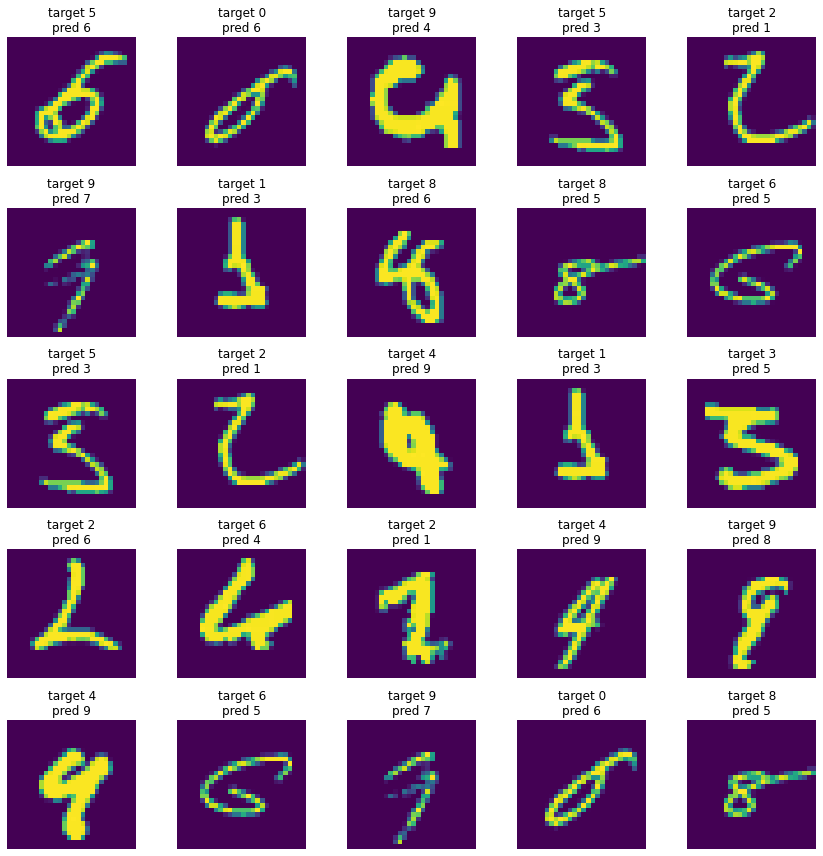

In [ ]:
import random

num_images = 25
fig = plt.figure(figsize=(12, 12))
for idx, (image, pred, target) in enumerate(random.choices(misclassified, k=num_images)):
    image, pred, target = image.cpu().numpy(), pred.cpu(), target.cpu()
    ax = fig.add_subplot(5, 5, idx+1)
    ax.axis('off')
    ax.set_title('target {}\npred {}'.format(target.item(), pred.item()), fontsize=12)
    ax.imshow(image.squeeze())
plt.tight_layout()
plt.show()